# SVM

- Based on the distance between two closest points belonging to different classes. This distance is called Margin distance given by ( distance = w.X + b ) and these points are called Support Vectors.

    `  Margin Distance = w.X + b`

    `  Margin = (w.X + b)Y_i = 1/||w||`

    `  Optimisation Function: Max Margin = Max(1/||w||) = Min(||w||) ~= Min 1/2 ||w||^2`
    

- To Solve this optimisation problem, we use Larange Multipliers.

## AIM

----

## Data

`Dataset = 'pima-indians-diabetes'`

- This problem is comprised of 768 observations of medical details for Pima indians patents. 

- All patients are women aged 21 or older. All attributes are numeric, and their units vary from attribute to attribute.

- Each record has a class value that indicates whether the patient suffered an onset of diabetes within 5 years of when the measurements were taken Yes(1) or not(0).

- A good prediction accuracy is 70%

## Imports

In [87]:
import random
import numpy as np
import pandas as pd

# Tools
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV

# Evaluation Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer

# Model
from sklearn import svm

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Dataset

In [2]:
df = pd.read_csv('Data/data_5_2_pima-indians-diabetes.data.csv')
df.head()

,Level,Iron_content,Calcium_content,Vitamins_deficiency,Beta_nagative,Beta_postive,Blood_workout,Age,Class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.shape

(768, 9)

In [4]:
Features = df.columns[df.columns != 'Class']
Target = 'Class'

## Missing Value Treatment

In [5]:
df.isnull().sum()

Level                  0
Iron_content           0
Calcium_content        0
Vitamins_deficiency    0
Beta_nagative          0
Beta_postive           0
Blood_workout          0
Age                    0
Class                  0
dtype: int64

- No missing values

## Target Variable

In [6]:
df[Target].value_counts()

0    500
1    268
Name: Class, dtype: int64

- Not imbalanced, binary classification problem

In [7]:
df[Target].skew()

0.63501664344498598

## Exploration

In [8]:
df.corr()[Target].sort_values(ascending=False)

Class                  1.000000
Iron_content           0.466581
Beta_postive           0.292695
Age                    0.238356
Level                  0.221898
Blood_workout          0.173844
Beta_nagative          0.130548
Vitamins_deficiency    0.074752
Calcium_content        0.065068
Name: Class, dtype: float64

- 'Iron_content', 'Beta_postive', 'Age' seems to be the best features to define any model

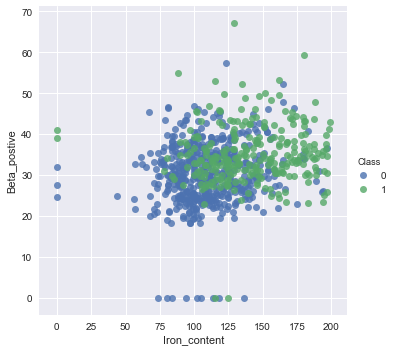

In [9]:
sns.lmplot('Iron_content', 'Beta_postive', df, hue=Target, fit_reg=False)

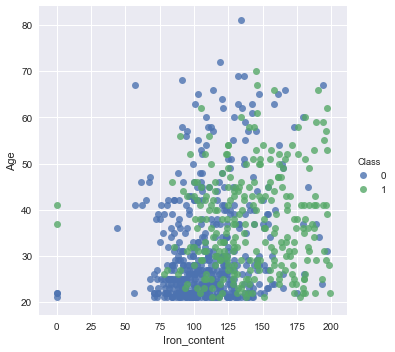

In [10]:
sns.lmplot('Iron_content', 'Age', df, hue=Target, fit_reg=False)

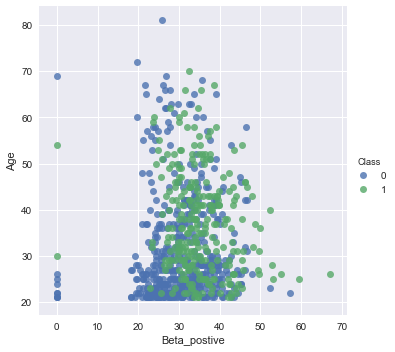

In [11]:
sns.lmplot('Beta_postive', 'Age', df, hue=Target, fit_reg=False)

- Shows the distribution of top 3 features with each other. 
- In general, with increasing values of all three features, the onset of diabetes seems positive (class = 1)
- Higher the value of these 3 features, more the chances of class = 1

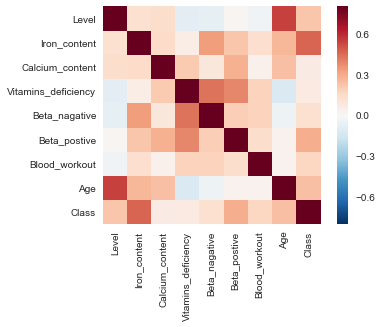

In [12]:
# Heatmap 
sns.heatmap(df.corr(), vmax=.8, square=True)

- 3 Features which have strong postive correlation with Target are the same I thought about. 'Iron_content' being the strongest

## Data Preparation

In [13]:
Top_Features = df.corr()[Target].sort_values(ascending=False).index[1:4]
Top_Features

Index([u'Iron_content', u'Beta_postive', u'Age'], dtype='object')

- Keeping the top features in hand for accuracy comparison later

In [14]:
X = df[Features]
Y = df[Target]

#### Standardisation

In [15]:
Standardise = StandardScaler()

In [16]:
Standardise.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [17]:
X = pd.DataFrame(Standardise.transform(X), columns=Features)

In [18]:
X_topFeatures = X[Top_Features]

## Model SVM

### 1. Model (Simple)

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

model = svm.SVC()
model.fit(X_train, Y_train)
Y_hat = model.predict(X_test)
accuracy_score(Y_test, Y_hat)

0.765625

In [20]:
print confusion_matrix(Y_test, Y_hat)

[[103   9]
 [ 36  44]]


In [21]:
print classification_report(Y_test, Y_hat)

             precision    recall  f1-score   support

          0       0.74      0.92      0.82       112
          1       0.83      0.55      0.66        80

avg / total       0.78      0.77      0.75       192



- Little overfitted on **'0'** than **'1'**.  As frequency of '0' is more than '1' as seen by **Recall** values for both. 
- Recall for 1 is lesser than for 0 by a good margin. Thus missclassifying '1's more.
- F1 Score (weighted average of Precision and Recall) is also overfitted on '0'.
- Total Accuracy is biased towards '0' a little bit.

#### Can write the above 5 lines in 1 using *'cross_val_score'* 

- `which instantiate the model ,`
- `Splits X,Y ,`
- `and finds the accuracy too`

In [22]:
scores = cross_val_score(model, X, Y, cv=10, scoring='accuracy')
scores.mean()

0.76168831168831175

### 2. Model (Hyper-parameter Tuning using GridSearchCV)

Parameters -

    - C-value (Penalty term added to reduce missclassifications case; lower value - Soft margin, Higher value - overfitting)
    - decision _function_shape ('ovr' one Vs rest  or 'ovo' one Vs one that helps in multiple class problems)
    - kernel ('linear' for linear hyperplanes, 'rbf' radial bias function for non-linear hyperplanes, 'poly' or 'sigmoid)
    - gamma (smoothness of decision boundaries, higher value - overfitting model)

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

### Example: C - value

In [91]:
# C too low
model = svm.SVC(C=0.001)
cross_val_score(model, X,Y, cv=10, scoring='accuracy').mean()

0.65105946684894056

- Underfit model

In [95]:
# C too high
model = svm.SVC(C=100)
cross_val_score(model, X,Y, cv=10, scoring='accuracy').mean()

0.70584415584415583

- overfit model

### Using GridSearchCV

In [71]:
# a dict of some model hyper-parameters
grid_params = {'C': np.random.uniform(0.4, 1.5 , size=10),
               'decision_function_shape':['ovr', 'ovo', None],
               'kernel': ['linear', 'rbf'],
               'gamma': [0.50, 0.100, 0.125, 0.150]}

In [85]:
# Passing a model, grid parameters, cv, and evaluation metrics. 
# -> For Regression models,      scoring='mean_squared_error'
# -> For Classification models,  scoring='accuracy'

grid = GridSearchCV(model, grid_params, cv=10, scoring='accuracy')

In [74]:
grid.fit(X,Y)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=20, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ['linear', 'rbf'], 'C': array([ 0.72698,  0.9252 ,  1.13354,  1.17853,  0.57327,  0.46383,
        0.8977 ,  1.1833 ,  0.70802,  1.06652]), 'decision_function_shape': ['ovr', 'ovo', None], 'gamma': [0.5, 0.1, 0.125, 0.15]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

#### Best Score

In [82]:
grid.best_score_

0.7721354166666666

#### Best set of parameters

In [84]:
grid.best_params_

{'C': 0.72697592147073964,
 'decision_function_shape': 'ovr',
 'gamma': 0.5,
 'kernel': 'linear'}

#### Best SVM model object

In [80]:
grid.best_estimator_

SVC(C=0.72697592147073964, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.5, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Final Predictions

In [113]:
# Fitting model with best parameters found using  "GridSearchCV"
model = svm.SVC(C=0.73, decision_function_shape='ovr', kernel='linear', gamma=0.5)

# With all features...
print "Accuracy(all features) =", round(cross_val_score(model, X, Y, cv=10, scoring='accuracy').mean()*100, 2), "%"

# With top 3 features...
print "Accuracy(Top 3 features) =", round(cross_val_score(model, X_topFeatures, Y, cv=10, scoring='accuracy').mean()*100, 2), "%"

Accuracy(all features) = 77.22 %
Accuracy(Top 3 features) = 76.44 %


- Our model is 78 % accurate